# GİRİŞ
Burada veri setinin alınması, özelliklerin çıkarılması ve eğitime hazırlanması sağlanacaktır.

## Gerekli Modüller
- Numpy verileri eğitime hazırlanmak ve daha öncesinde kayıt edilen numpy veri dosyaların alınması için kullanılacaktır.
- Librosa tek boyutlu ses sinyallerinden mel frekans spektrogram katsayısını çıkarmak için kullanılacaktır.
- Matplotlib ise sonuçları görselleştirmek amacıyla kullanılacaktır.

In [ ]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt

## Veri Setinin Okunması
Veri setinin dinamik bir şekilde kullanılması açısından daha öncesinden kayıt edilmişti. Kaydedilen numpy dosyaları okundu.

In [ ]:
data = np.load("/content/drive/MyDrive/Bitirme/Uygulama/Datasets/RAVDESS/data.npy") # verileri alınması
labels = np.load("/content/drive/MyDrive/Bitirme/Uygulama/Datasets/RAVDESS/labels.npy") # etiketlerin okunması

In [ ]:
labels.shape

(1440,)

## MFCC Özellik Çıkarıcı
Her bir ses dosyası gezilip mel frekans spektral katsayısı hesaplatıldı ve yeniden boyutlandırılıp features liste elemanına atandı.

In [ ]:
features = []
for i in data:
  features.append((lb.feature.mfcc(y=i).reshape(5520,1)))
features = np.array(features)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
LB = LabelBinarizer()
label = LB.fit_transform(labels)

In [ ]:
label.shape

(1440, 8)

## Veri Setinin Bölünmesi
Eğitim ve test işlemleri için tüm RAVDESS veri seti %80'e %20 olacak şekilde random (rastgele) bir şekilde ayrılıdı. Eğitim 1152 ve test 288 veri sayıları.

In [ ]:
from sklearn.model_selection import train_test_split
(x_train,x_test,y_train,y_test) = train_test_split(features,label,random_state = 10,test_size = 0.20)
print("Train Veri Sayısı:",x_train.shape[0])
print("Test Veri Sayısı:",x_test.shape[0])

Train Veri Sayısı: 1152
Test Veri Sayısı: 288


In [ ]:
y_train.shape

(1152, 8)

# Model

## Model Modülleri
Model için gerekli modeüllerin ve fonksiyonların tanımlanması.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

## Modelin Oluşturulması
Model tek katmanlı evrişimli sinir ağı olarak tasarlandı.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=256,kernel_size=5, input_shape=(5520,1), activation='relu',padding='same'))
model.add(Conv1D(128, 5,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

## Modelin Derlenmesi
Optimizasyon algoritması olarak Rmsprop seçildi. Başlangıç öğrenme oranı (lr) 0.0001 kayıp fonksiyonu olarak 'categorical_crossentropy' başarı metriği doğruluk olarak belirlendi.

In [ ]:
opt = RMSprop(lr=0.00001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary() # Modelin Özeti 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5520, 256)         1536      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5520, 128)         163968    
_________________________________________________________________
dropout (Dropout)            (None, 5520, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 690, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 690, 128)          82048     
_________________________________________________________________
flatten (Flatten)            (None, 88320)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 7

## Modelin Eğitimi
Eğitimde eğitim (train) ve doğrulama (validation) veriyle 40 dönem-defa (epoch) 10 mini-batchler halinde eğitildi. Eğitim sonuçları cnnhistory değişkenine atandı.

In [ ]:
cnnhistory=model.fit(x_train, y_train, batch_size= 10, epochs=40, validation_data=(x_test,y_test))

Epoch 1/40
116/116 [==============================] - 47s 35ms/step - loss: 3.7847 - accuracy: 0.1771 - val_loss: 3.0003 - val_accuracy: 0.2049
Epoch 2/40
116/116 [==============================] - 3s 30ms/step - loss: 2.0771 - accuracy: 0.3134 - val_loss: 2.8700 - val_accuracy: 0.2465
Epoch 3/40
116/116 [==============================] - 3s 30ms/step - loss: 1.8240 - accuracy: 0.3712 - val_loss: 2.0948 - val_accuracy: 0.2708
Epoch 4/40
116/116 [==============================] - 3s 30ms/step - loss: 1.5070 - accuracy: 0.4681 - val_loss: 2.2992 - val_accuracy: 0.2674
Epoch 5/40
116/116 [==============================] - 3s 30ms/step - loss: 1.4060 - accuracy: 0.4772 - val_loss: 1.7234 - val_accuracy: 0.3750
Epoch 6/40
116/116 [==============================] - 3s 30ms/step - loss: 1.2228 - accuracy: 0.5417 - val_loss: 1.6133 - val_accuracy: 0.4201
Epoch 7/40
116/116 [==============================] - 3s 30ms/step - loss: 1.1294 - accuracy: 0.5985 - val_loss: 2.0580 - val_accuracy: 0.305

# Modelin Sonuçları

## Modelin Test Edilmesi
Test için ayrılan veriler ile model 5 mini-batchler halinde test edildi

In [ ]:
score = model.evaluate(x_test,y_test,batch_size=5)

58/58 [==============================] - 1s 7ms/step - loss: 1.8340 - accuracy: 0.5382


## Doğruluk ve Kayıp Sonuçları
Eğitim sonuçları grafiksel olarak görselleştirildi.

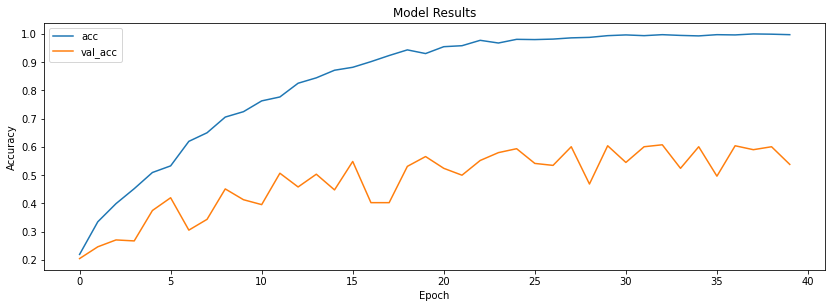

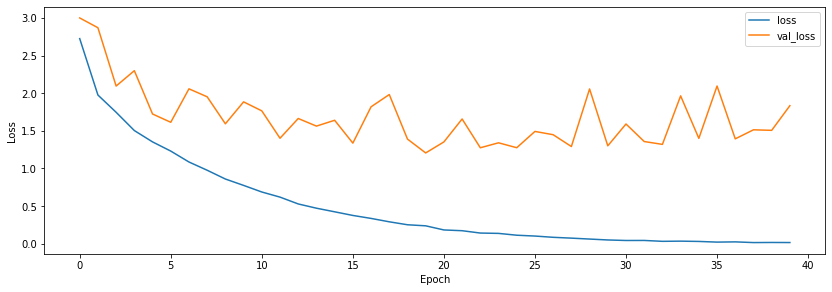

In [ ]:
plt.figure(1, figsize = (14, 10))  
plt.subplot(211)  
plt.plot(cnnhistory.history['accuracy'])  
plt.plot(cnnhistory.history['val_accuracy'])  
plt.title('Model Results')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['acc', 'val_acc'], loc='upper left')     
plt.show()
plt.figure(2, figsize = (14, 10))  
plt.subplot(212)  
plt.plot(cnnhistory.history['loss'])  
plt.plot(cnnhistory.history['val_loss'])   
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['loss', 'val_loss'], loc='upper right')     
plt.show()

# Sınıflandırmanın raporunun ve karmaşılık matrisinin çıkarımı


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=["Angry","Calm","Disgust","Fear","Happy","Netural","PS","Sad"])
conf_mat = confusion_matrix(true_classes, predicted_classes)

In [ ]:
print(report)

              precision    recall  f1-score   support

       Angry       0.69      0.55      0.61        40
        Calm       0.65      0.65      0.65        37
     Disgust       0.77      0.57      0.66        40
        Fear       0.48      0.43      0.45        35
       Happy       0.77      0.32      0.45        31
     Netural       0.78      0.29      0.42        24
          PS       0.33      0.81      0.47        37
         Sad       0.53      0.55      0.54        44

    accuracy                           0.54       288
   macro avg       0.62      0.52      0.53       288
weighted avg       0.62      0.54      0.54       288



In [ ]:
label_names = ["Ang","Cal","Dis","Fe ","Hap","Net","PS ","Sad"]
print("     Ang   Cal  Dis  Fe   Hap  Net  PS   Sad")
sayac = 0
for i in conf_mat:

    st = ""
    for j in i:
        st = st + "  " +str(j)+"  "
    print(label_names[sayac],st)
    sayac +=1

     Ang   Cal  Dis  Fe   Hap  Net  PS   Sad
Ang   22    0    2    0    0    0    14    2  
Cal   1    24    3    3    0    0    3    3  
Dis   3    1    23    2    0    0    5    6  
Fe    0    0    1    15    0    0    14    5  
Hap   4    1    0    3    10    0    11    2  
Net   0    5    0    0    1    7    9    2  
PS    1    1    0    3    1    0    30    1  
Sad   1    5    1    5    1    2    5    24  
